# **Identifying Manga with Convolutional Neural Networks**
In this project, I will be training a Convolutional Neural Network with the objective of differentiating between manga pages from 2 different series. I chose Naruto and Bleach as both are long running series from which we can obtain a total of 24,000 unique pages to train our model.

Humans have heuristics to rely on such as artstyle or knowledge of characters and settings when figuring which series a random manga page belongs to. It would be interesting to see if we can train a CNN to recognize such properties and maybe even surpass human differentiability.

There will be 3 main models/approaches we will explore and compare in this exercise.




1.   A basic CNN with 3 layers
2.   Augmenting the imageset with random transforms and adding dropout to the CNN to regularize
3. Extracting features from the pre-trained [InceptionV3](https://arxiv.org/abs/1512.00567) and fine-tuning the top layer





### Data Organizing

The data for this project comes in the form of 12,000 pages each of Naruto and Bleach. 10,000 are set for Training and 2,000 are set for Testing. The actual series of each contains around 1000 more pages but many of which consist mostly of whitespace such as tables of contents, bonus doodles, and other assorted filler. The remaining 12,000 pages consist entirely of the main pages of each chapter.

We host a zip file and unzip it here to avoid the overhead that comes with each call of the generator functions when training the model. Storing the images in a tmp directory leads to significantly faster training times than calling from Google Drive per epoch.

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os
import random
import shutil

In [4]:
# Mounting our drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#Unzipping our dataset to a temporary directory to improve runtime
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/TestTrain.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [8]:
# The tmp directory that we unzipped to
base_dir = '/tmp/content/drive/My Drive/Manga/TrainTest/'

# Creating training and validation directories for our generators to get data from.
train_dir = os.path.join(base_dir, 'Train')
train_bleach_dir = os.path.join(train_dir, 'Bleach')
train_naruto_dir = os.path.join(train_dir, 'Naruto')

validation_dir = os.path.join(base_dir, 'Test')
validation_bleach_dir = os.path.join(validation_dir, 'Bleach')
validation_naruto_dir = os.path.join(validation_dir, 'Naruto')

# Creating a list of file names
train_bleach_fnames = os.listdir(train_bleach_dir)
train_naruto_fnames = os.listdir(train_naruto_dir)

We check that we have the correct number of files.

In [9]:
# We expect 10,000 in each training folder and 2,000 in the validations
print('Total training Bleach images:', len(os.listdir(train_bleach_dir)))
print('Total training Naruto images:', len(os.listdir(train_naruto_dir)))
print('Total validation Bleach images:', len(os.listdir(validation_bleach_dir)))
print('Total validation Naruto images:', len(os.listdir(validation_naruto_dir)))

Total training Bleach images: 10000
Total training Naruto images: 10000
Total validation Bleach images: 2000
Total validation Naruto images: 2000


# **Building a 3 layer Convolution Neural Network**

We resize the pages to 150x150 to be less taxing on the model. A reader of both series is still able to discern between the 150x150 images.

For our first attempt at the architecture, we will use a convolution of  3x3 windows, Rectified Linear Units (ReLU), and pool using max with 2x2 windows. We will structure the layers such that we first extract 16 features, then 32, then lastly 64. 

We've chosen this setup due to prior research indicating that this configuration works well for image classification. We also want to keep things simple as of now to minimize the risk of overfitting, which we can address later on as a further improve our model.

Our classification problem only involves 2 categories. We will end our network with a sigmoid activation which is appropriate for binary classifications. Our end result is a value between 0 and 1 indicating the probability that our image falls into a certain class. 

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# Shape is resolution and 3 for the RGB channels
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 3x3 filters and then by max-pooled with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# First convolution extracts 32 3x3 filters and then by max-pooled with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# First convolution extracts 64 3x3 filters and then by max-pooled with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

We can take a look at the structure of our model below.  Here we can see the outputs structures after each file traverses a layer of the network.

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0   

### Data Preprocessing

We can now create data generators which will flow from our temporary directories to read images, convert to tensors, and then become inputs with labels to our network. We generate for both the training and validations. Given the size of our dataset, I chose a large batch size of 200.

Images will also be normalized during this preprocessing step. We scale down pixel values to a 0 to 1 range by dividing with 255.

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize the pixel values
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Generate training data by flowing from our tmp directory, 200 at a time
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(150, 150),  
        batch_size=200,
        class_mode='binary')

# Generate validation data by flowing from our tmp directory, 200 at a time
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=200,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


###Looking at the Resized Images

Before we go on to training the data, we can take a quick look at the kind of data we're generating. We randomly sample a few pages from each series in the training set to get a sense of what our model will be looking at.

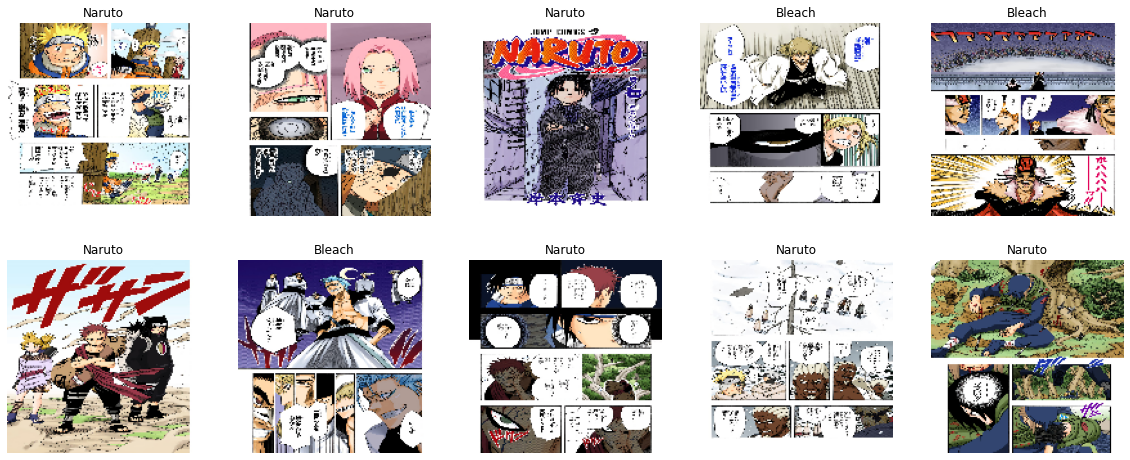

In [48]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 0

# 5 images for each series
nrows = 2
ncols = 5

img_array = train_generator[0][0]
labels = train_generator[0][1]
labels = ['Bleach' if x == 0.0 else 'Naruto' for x in labels]


fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i in range(10):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  plt.imshow(img_array[i])
  plt.title(labels[i])

plt.show()

In [44]:
train_generator.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

### Training
We have our model structure and our data generators set up and are ready to train with 15 epoch in our initial run. 

We will keep an eye out for overfitting which can occur when our model tunnel-visions into the training set and memorizes noise. If performance seems to show signs of this (Validation Accuracy decreasing and Validation Loss increasing) we can tweak our model to overcome this. 

In [12]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  
      epochs=15,
      validation_data=validation_generator,
      validation_steps=20, 
      verbose=2)

Epoch 1/15
100/100 - 1475s - loss: 0.4091 - acc: 0.8228 - val_loss: 0.3501 - val_acc: 0.8572
Epoch 2/15
100/100 - 1481s - loss: 0.2988 - acc: 0.8741 - val_loss: 0.2214 - val_acc: 0.9118
Epoch 3/15
100/100 - 1492s - loss: 0.2103 - acc: 0.9151 - val_loss: 0.2121 - val_acc: 0.9150
Epoch 4/15
100/100 - 1486s - loss: 0.1586 - acc: 0.9346 - val_loss: 0.2062 - val_acc: 0.9170
Epoch 5/15
100/100 - 1491s - loss: 0.1313 - acc: 0.9506 - val_loss: 0.1253 - val_acc: 0.9513
Epoch 6/15
100/100 - 1488s - loss: 0.0925 - acc: 0.9641 - val_loss: 0.1213 - val_acc: 0.9575
Epoch 7/15
100/100 - 1482s - loss: 0.0783 - acc: 0.9730 - val_loss: 0.2628 - val_acc: 0.9100
Epoch 8/15
100/100 - 1496s - loss: 0.0963 - acc: 0.9736 - val_loss: 0.2575 - val_acc: 0.9068
Epoch 9/15
100/100 - 1481s - loss: 0.0417 - acc: 0.9865 - val_loss: 0.1470 - val_acc: 0.9603
Epoch 10/15
100/100 - 1491s - loss: 0.0393 - acc: 0.9872 - val_loss: 0.1422 - val_acc: 0.9635
Epoch 11/15
100/100 - 1487s - loss: 0.0361 - acc: 0.9889 - val_loss: 

### Evaluating Accuracy and Loss for the Model

When we plot our accuracy and losses over the epochs, we find a minor possible issue with overfitting starting starting around the 7th epoch. The orange line, representing validation metrics, starts to fluctuate midway through the epochs while the blue training line remained smooth. Overall the model performs very well, with a final validation accuracy of 96%. 


Text(0.5, 1.0, 'Loss by Training and Validation')

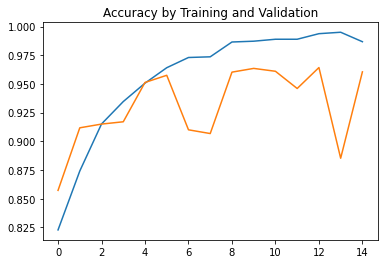

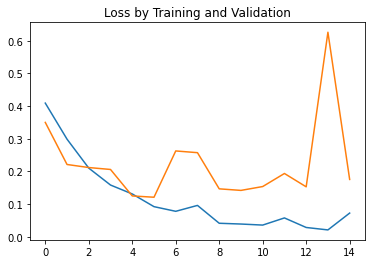

In [ ]:
# Getting accuracy and losses for our training and validation data sets for plotting
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plotting training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Accuracy by Training (Blue) and Validation (Orange)')

plt.figure()

# Plotting training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Loss by Training (Blue) and Validation (Orange)')

# **Attempting a Model with Image Augmentation and Dropout**

# Image Augmentation

One method of preventing overfit is data augmentation. For a convnet, this would involve slightly altering the images that our training data generator produces for each epoch. This way, we ensure that our model never sees the exact same image twice which should lead to better generalizability. The image alterations we will add to our data generator are:



1.   Randomly rotating our images from 0 to 40 degrees.
2.   Shifting our images vertically or horizontally up to 20%.
3. Shear transformation randomly 20%.
4. Zooming randomly 20%.
5. Flipping half of our images horizontally.
6. Filling in newly created pixels.


In [13]:
# Creating an augmented training data generator. This is same as before with some random transformations.
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Same generator as before, but using the augmented data generator
train_generator_aug = train_datagen_aug.flow_from_directory(
        train_dir, 
        target_size=(150, 150),  
        batch_size=200,
        class_mode='binary')

Found 20000 images belonging to 2 classes.


### Dropout

In addition, we can also incorporate Dropout, a form of regularization which involves temporarily removing nodes in our network. The purpose of this is to prevent our model from structuring around the interdependent noise rather than the signal from our training set. We pick a rate of 50% which means that half of our nodes before the final classifcation layer will not activate.

In [14]:
# This code is identical to the previous model, just with an extra dropout line near the end.

#The following block is just the exact same model structure
img_input = layers.Input(shape=(150, 150, 3))
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)

# This is the only new line of code
x = layers.Dropout(0.5)(x) 

output = layers.Dense(1, activation='sigmoid')(x)
model_dropout = Model(img_input, output)

model_dropout.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['acc'])

###Retraining


In [15]:
#Same values, just using the dropout model and the augmented train_generator
history = model_dropout.fit(
      train_generator_aug,
      steps_per_epoch=100,  
      epochs=15,
      validation_data=validation_generator,
      validation_steps=20, 
      verbose=2)

Epoch 1/15
100/100 - 1586s - loss: 0.7426 - acc: 0.6520 - val_loss: 0.4585 - val_acc: 0.7818
Epoch 2/15
100/100 - 1583s - loss: 0.5128 - acc: 0.7585 - val_loss: 0.8164 - val_acc: 0.5163
Epoch 3/15
100/100 - 1591s - loss: 0.4515 - acc: 0.8004 - val_loss: 0.3730 - val_acc: 0.8338
Epoch 4/15
100/100 - 1570s - loss: 0.4087 - acc: 0.8241 - val_loss: 0.7608 - val_acc: 0.6510
Epoch 5/15
100/100 - 1581s - loss: 0.3774 - acc: 0.8398 - val_loss: 0.4638 - val_acc: 0.7865
Epoch 6/15
100/100 - 1579s - loss: 0.3287 - acc: 0.8648 - val_loss: 0.7294 - val_acc: 0.6805
Epoch 7/15
100/100 - 1590s - loss: 0.3080 - acc: 0.8715 - val_loss: 0.7020 - val_acc: 0.7030
Epoch 8/15
100/100 - 1593s - loss: 0.2829 - acc: 0.8851 - val_loss: 1.8559 - val_acc: 0.5770
Epoch 9/15
100/100 - 1575s - loss: 0.2672 - acc: 0.8910 - val_loss: 0.3586 - val_acc: 0.8285
Epoch 10/15
100/100 - 1585s - loss: 0.2479 - acc: 0.9007 - val_loss: 0.4621 - val_acc: 0.8085
Epoch 11/15
100/100 - 1583s - loss: 0.2302 - acc: 0.9065 - val_loss: 

### Evaluating Accuracy and Loss for the Second Model

We can immediately see that our Validation Accuracy and Loss perform worse than our original model and flucuates wildly with runs. One caveat of techniques like image augmentation and dropout is information loss and running the risk of rendering some data invalid. 

Some forms of augmentation that can lead to worse results with certain image data. I suspect that the horizontal flips and random rotations of the pages may have harmed out data. Manga pages are orientated specifically upright as opposed to images of animals which could have them take any pose. Shearing and zooming randomly may have also added inappropriate noise to paneling, which is an art in and of itself in manga.

It is also possible that our dataset was large enough that our model did not require augmentation or dropout regularization for improvement. Our symptoms of overfitting were weak after all. If I were to continue exploring overfit though, I would use less types of image transformation. I would also consider using Batch Normalization rather than Dropout, a regularization approach that some consider more modern.

Text(0.5, 1.0, 'Loss by Training (Blue) and Validation (Orange)')

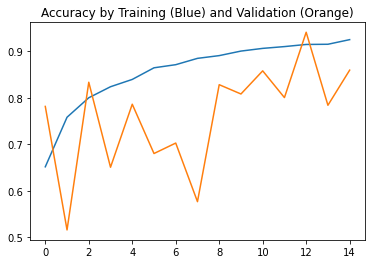

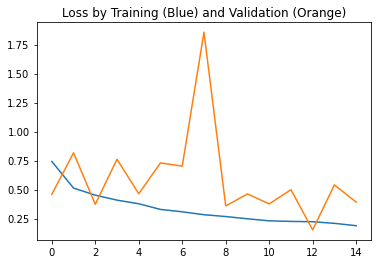

In [21]:
# Getting accuracy and losses for our training and validation data sets for plotting
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plotting training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Accuracy by Training (Blue) and Validation (Orange)')

plt.figure()

# Plotting training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Loss by Training (Blue) and Validation (Orange)')

# **Feature Extraction and Fine-Tuning with Inception V3**

The final approach we explore involves transfer learning with feature extractions, which invokes the phenomenon of deep neural networks learning similar features when trained on image data. This includes textures, edges, and color patterns to name a few. The [Inception V3 model](https://arxiv.org/abs/1512.00567) is trained on over 1 million images and 1000 classes, which we can use as a base before training it to fit our data. 

Although these models are trained for different tasks, they likely share some commonalities which we could leverage for our goal. We want to see if we could successfully repurpose a much larger pre-trained model for our computer vision task. We pick the final layer of Inception V3 before flattening to act as our base. We first download the weights.

In [22]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

#importing the model and specifying input shapes that match our dataset
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

#this ensures that the model will not be trained; we'll only extract its features while training
for layer in pre_trained_model.layers:
  layer.trainable = False

#getting the last layer
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

--2021-02-22 22:12:18--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   118MB/s    in 0.7s    

2021-02-22 22:12:19 (118 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape: (None, 7, 7, 768)


Now that we have our base, we could append a fully connected classifier. This is similar to our previous structure.

In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model_V3 = Model(pre_trained_model.input, x)
model_v3.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

This is our final model for this approach. We will now train with our original dataset. We are limiting this to only 2 Epoch in training as this model is much larger and will thus take a long time to train otherwise.

In [ ]:
history = model_V3.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=20,
      verbose=2)

We see that the results are great.

## Fine-Tuning our model

We successfully repurposed a larger model with feature extraction and just 2 dense layers above it. We can get even better results by fine-tuning the weights of just the top layers of the pretrained model and our top classifier. We limit our fine-tuning to only the top layers because these tend to be more specialized features which may only be pertinent to the original task. This way, we can mold the layer to adapt the specialized features learned to become relevant to our dataset. 

In [ ]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use Stochastic Gradient Descent with a very low learning rate
model_V3.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])